In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from plotting_constants import nice_names, color_dict, stack_to_ax

In [4]:
path = str(Path.cwd().parent / 'summaries' / 'total_summary_revenues_flex_{}.csv')
rev = pd.read_csv(path.format('national'), index_col=0, header=[0,1,2], parse_dates=True)

In [5]:
pd.date_range(rev.index[0], rev.index[-1], freq='30min').difference(rev.index)

DatetimeIndex(['2022-08-08 23:00:00', '2022-08-08 23:30:00',
               '2022-08-09 00:00:00', '2022-08-09 00:30:00',
               '2022-08-09 01:00:00', '2022-08-09 01:30:00',
               '2022-08-09 02:00:00', '2022-08-09 02:30:00',
               '2022-08-09 03:00:00', '2022-08-09 03:30:00',
               ...
               '2024-09-26 18:00:00', '2024-09-26 18:30:00',
               '2024-09-26 19:00:00', '2024-09-26 19:30:00',
               '2024-09-26 20:00:00', '2024-09-26 20:30:00',
               '2024-09-26 21:00:00', '2024-09-26 21:30:00',
               '2024-09-26 22:00:00', '2024-09-26 22:30:00'],
              dtype='datetime64[ns]', length=1200, freq=None)

In [6]:
mapping_dict = {
    'wholesale': 'wholesale',
    'offers': 'offer_cost',
    'bids': 'bid_cost',
    'cfd': 'cfd_payments',
    'roc': 'roc_payments',
    'wholesale selling': 'wholesale selling',
    'wholesale buying': 'wholesale buying',
}

In [7]:
nice_titles = {
    'north disp': 'North Thermal',
    'south disp': 'South Thermal',
    'north hydro': 'North Hydro',
    'south hydro': 'South Hydro',
    'north storage': 'North Storage',
    'south storage': 'South Storage',
    'north wind': 'North Wind',
    'south wind': 'South Wind',
    'total intercon': 'Interconnectors',

}

C:\Users\lukas\AppData\Local\Temp\ipykernel_488\292131420.py:63: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cost_summary = pd.read_csv(Path.cwd().parent / 'results' / f'{date}' / 'system_cost_summary_flex.csv',


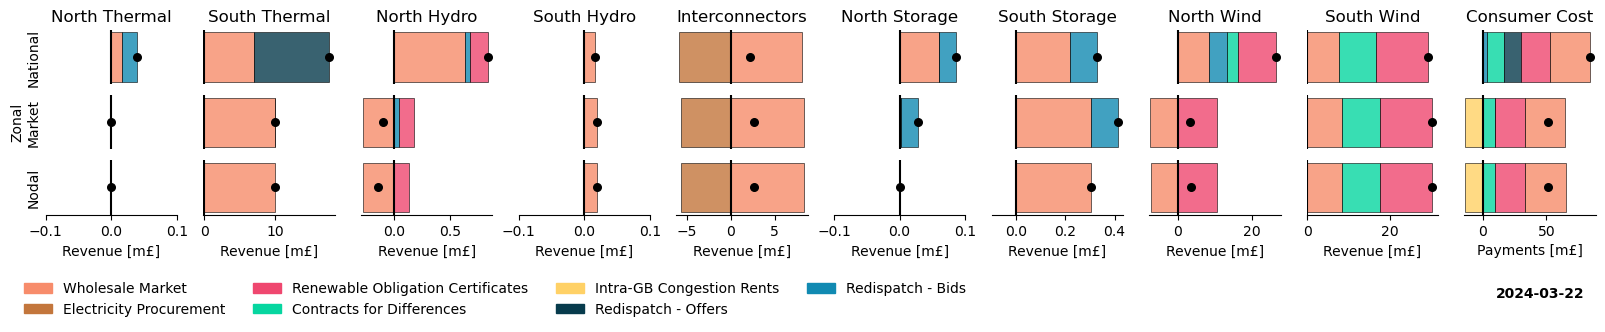

In [8]:
# =============================================================================
# Helper function: Plot a horizontal stacked bar on a given axis
# =============================================================================
def plot_stacked_bar(ax, data, color_mapping, bar_kwargs=None, scatter_kwargs=None, y=0):
    """
    Plots a horizontal stacked bar on the provided axis `ax` based on a pandas Series `data`.

    Parameters:
        ax: matplotlib.axes.Axes
            The axis on which to plot.
        data: pd.Series
            A series with numeric values (both positive and negative). The index
            contains the category labels.
        color_mapping: dict or callable
            If a dict, keys from data.index are looked up to return colors.
            If callable, it should accept a key and return a color.
        bar_kwargs: dict, optional
            Additional keyword arguments for ax.barh.
        scatter_kwargs: dict, optional
            Additional keyword arguments for ax.scatter.
        y: float, optional
            The y coordinate at which to plot the bar (default is 0).
    """
    if bar_kwargs is None:
        bar_kwargs = dict(edgecolor='k', linewidth=0.5, alpha=0.8)
    if scatter_kwargs is None:
        scatter_kwargs = dict(color='k', s=30)

    # Separate negative and positive values.
    neg = data[data < 0]
    pos = data[data > 0]

    # Plot negative contributions (stacked from left of zero)
    for i, key in enumerate(neg.index):
        value = neg.loc[key]  # a negative number
        cum_neg = neg.iloc[:i+1].sum()  # cumulative negative sum up to this bar
        color = color_mapping(key) if callable(color_mapping) else color_mapping.get(key, 'gray')
        ax.barh(y=y, left=cum_neg, width=-value, color=color, **bar_kwargs)
    
    # Plot positive contributions (stacked starting at zero)
    for i, key in enumerate(pos.index):
        value = pos.loc[key]
        left = pos.iloc[:i].sum() if i > 0 else 0
        color = color_mapping(key) if callable(color_mapping) else color_mapping.get(key, 'gray')
        ax.barh(y=y, left=left, width=value, color=color, **bar_kwargs)
    
    # Mark the total value with a scatter point
    total = data.sum()
    ax.scatter([total], [y], **scatter_kwargs)


# =============================================================================
# Main plotting code
# =============================================================================

date = '2024-03-22'
# date = '2024-12-02'
# date = 'total'  # if date is 'total' this plots cumulative revenues for the whole 3-year period

scale_factor = 1e-9 if date == 'total' else 1e-6

if date != 'total':
    cost_summary = pd.read_csv(Path.cwd().parent / 'results' / f'{date}' / 'system_cost_summary_flex.csv', 
                               index_col=[0,1], parse_dates=True)
else:
    cost_summary = pd.read_csv(Path.cwd().parent / 'summaries' / 'total_summary_flex.csv', 
                               index_col=[0,1], parse_dates=True)

idx = pd.IndexSlice

# (Note: the following 'total = rev.sum()' line is from your original code,
# but rev is defined later. You might remove or reposition it as needed.)
# total = rev.sum()

fig, axs = plt.subplots(3, 10, figsize=(20, 2.4))

for ax in axs.flatten():
    ax.axvline(0, color='k')

totals = {}

# Prepare x-axis limits for the eight columns (0 through 7)
xlim_lower = np.zeros(len(axs[0])) - 0.1
xlim_upper = np.zeros(len(axs[0])) + 0.1

bar_kwargs = dict(
    edgecolor='k',
    linewidth=0.5,
    alpha=0.8
)

# Loop over the three market layouts.
for k, (axs_row, layout) in enumerate(zip(axs, ['national', 'zonal', 'nodal'])):

    totals[layout] = {}

    if date != 'total':
        fn = str(Path.cwd().parent / 'results' / '{}'  / 'bmu_revenues_flex_{}.csv').format(date, layout)
    else:
        fn = str(Path.cwd().parent / 'summaries' / 'total_summary_revenues_{}.csv').format(layout)

    df = pd.read_csv(
        fn,
        index_col=0,
        header=[0,1,2],
        parse_dates=True
    )
    
    # Exclude 'load' columns and scale revenues
    rev = df.loc[:, ~df.columns.get_level_values(1).str.contains('load')].mul(scale_factor)

    # ------------------------------
    # Plot the System Cost (Load Payment) bar in the last subplot of the row.
    # ------------------------------
    load_payment = (
        cost_summary[layout]
        .unstack()
        .sum()
        .drop('balancing_volume')
        .mul(scale_factor)
        .mul(1e6)  # dataset comes in millions
    )
    total_load = load_payment.sum()

    neg = load_payment[load_payment < 0]
    pos = load_payment[load_payment > 0]

    xlim_lower[-1] = min(xlim_lower[-1], neg.sum() * 1.05)
    xlim_upper[-1] = max(xlim_upper[-1], pos.sum() * 1.05)

    # Here we call our helper function instead of looping manually.
    plot_stacked_bar(ax=axs_row[-1],
                     data=load_payment,
                     color_mapping=color_dict,
                     bar_kwargs=bar_kwargs,
                     scatter_kwargs={'color': 'k', 's': 30},
                     y=0)

    # ------------------------------
    # Plot the revenue groups in the remaining subplots.
    # ------------------------------
    totals[layout] = {}

    # The grouping is done by revenue type (place and carrier)
    for j, i in enumerate(rev.T.groupby(level=[0,1]).sum().T.sum().sort_index(level=1).index):
        ax = axs_row[j]
        place, carrier = i

        ss = rev.loc[:, idx[place, carrier, :]].sum()
        ss.index = ss.index.droplevel([0,1])
        totals[layout][f'{place} {carrier}'] = ss

        total_ss = ss.sum()
        neg = ss[ss < 0]
        pos = ss[ss > 0]

        xlim_lower[j] = min(xlim_lower[j], neg.sum() * 1.05)
        xlim_upper[j] = max(xlim_upper[j], pos.sum() * 1.05)

        # For revenue groups, the color is chosen via mapping_dict.
        plot_stacked_bar(ax=ax,
                         data=ss,
                         color_mapping=lambda key: color_dict[mapping_dict[key]],
                         bar_kwargs=bar_kwargs,
                         scatter_kwargs={'color': 'k', 's': 30},
                         y=0)

        if k == 0:
            ax.set_title(nice_titles[f'{place} {carrier}'])
        
    # Tidy up the axes in this row.
    for ax in axs_row:
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if k < 2:
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])

# Set the x-axis limits for columns 0 through 6 (the revenue group subplots)
for i in range(len(axs[0])):
    for ax in axs[:, i]:
        ax.set_xlim(xlim_lower[i], xlim_upper[i])

# Add a text label for the System Cost subplot (last column)
axs[2, -1].text(
    xlim_upper[-1] * 0.9,
    -1.78,
    f'{date}' if date != 'total' else '2022-2024',
    weight='bold',
    fontsize=10,
    ha='right',
)

for ax in axs[2, :-1]:
    ax.set_xlabel('Revenue [m£]' if date != 'total' else 'Revenue [bn£]')

axs[-1, -1].set_xlabel('Payments [m£]' if date != 'total' else 'Payments [bn£]')
axs[0, -1].set_title('Consumer Cost')

# Create legend handles and labels.
handles, labels = [], []
for name, nice_name in nice_names.items():
    handles.append(plt.Rectangle((0, 0), 1, 1, color=color_dict[name]))
    labels.append(nice_name)

axs[2, 0].legend(
    handles,
    labels,
    bbox_to_anchor=(7.1, -1.),
    frameon=False,
    ncol=4
)

for ax, label in zip(axs[:, 0], ['National', 'Zonal\nMarket', 'Nodal']):
    ax.set_ylabel(label)

plt.savefig('agg_revenues_{}.pdf'.format(date), bbox_inches='tight')
plt.show()

In [2]:
def f(x):
    x = 3

a = 2
f(a)
a

2

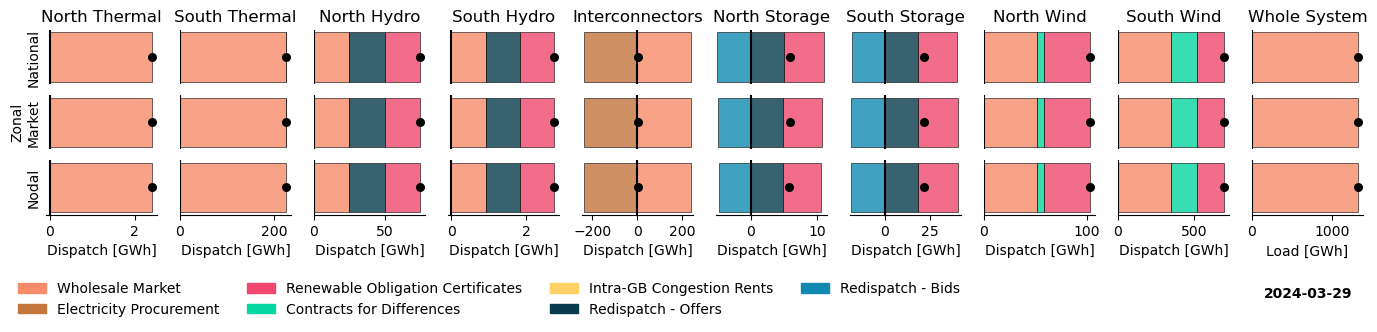

In [10]:
# =============================================================================
# Main plotting code (plotting dispatch per generator group)
# =============================================================================

# date = '2022-06-22'
# date = '2024-12-02'
# date = 'total'  # if date is 'total' this plots cumulative dispatch for the whole 3-year period

# For dispatch (in GWh) we use a scale factor of 1.
if date != 'total':
    scale_factor = 1e-3
else:
    scale_factor = 1e-6


# (If you no longer need cost/summary info for dispatch, you can remove this section.)
# In this example we assume that system cost data is not needed for dispatch.
# If you do need to plot load payments you would read that here.

idx = pd.IndexSlice

fig, axs = plt.subplots(3, 10, figsize=(17, 2.4))

# Draw a vertical line at x=0 for each axis.
for ax in axs.flatten():
    ax.axvline(0, color='k')

totals = {}

# Prepare x-axis limits for the eight columns (columns 0 through 7)
xlim_lower = np.zeros(len(axs[0])) - 0.1
xlim_upper = np.zeros(len(axs[0])) + 0.1

bar_kwargs = dict(
    edgecolor='k',
    linewidth=0.5,
    alpha=0.8
)

# Loop over the three market layouts.
# (Assumes layouts are 'national', 'zonal', and 'nodal'.)
for k, (axs_row, layout) in enumerate(zip(axs, ['national', 'zonal', 'nodal'])):

    totals[layout] = {}

    if date != 'total':
        fn = str(Path.cwd().parent / 'results' / '{}'  / 'bmu_dispatch_flex_{}.csv').format(date, layout)
    else:
        # raise ValueError('No total dispatch data available yet.')
        fn = str(Path.cwd().parent / 'summaries' / 'total_summary_dispatch_{}.csv').format(layout)

    df = pd.read_csv(
        fn,
        index_col=0,
        header=[0, 1, 2],
        parse_dates=True
    )
    
    # If you want to restrict to generator groups only (and exclude load),
    # filter out any columns where level 1 contains 'load'. Adjust if needed.
    disp = df.loc[:, ~df.columns.get_level_values(1).str.contains('load')].mul(scale_factor)
    
    # ------------------------------
    # Plot the System Dispatch (Load) bar in the last subplot of the row.
    # ------------------------------
    # Here we assume that the dispatch dataframe contains a column
    # with the key ('total', 'load', 'wholesale') representing load dispatch.
    # system_dispatch = df.loc[:, idx['total', 'load', 'wholesale']].squeeze().mul(scale_factor)
    system_dispatch = df.loc[:, idx['total', 'load', :]].mul(1e-3).sum()
    system_dispatch.index = system_dispatch.index.droplevel([0, 1])
    total_sys = system_dispatch.sum()

    neg = system_dispatch[system_dispatch < 0]
    pos = system_dispatch[system_dispatch > 0]

    xlim_lower[-1] = min(xlim_lower[-1], neg.sum() * 1.05)
    xlim_upper[-1] = max(xlim_upper[-1], pos.sum() * 1.05)

    # Use the helper function to plot the stacked bar for system dispatch.
    plot_stacked_bar(ax=axs_row[-1],
                     data=system_dispatch,
                     color_mapping=color_dict,
                     bar_kwargs=bar_kwargs,
                     scatter_kwargs={'color': 'k', 's': 30},
                     y=0)

    # ------------------------------
    # Plot the dispatch per generator group in the remaining subplots.
    # ------------------------------
    totals[layout] = {}

    # Grouping is performed by the first two levels of the multi-index columns.
    # (For example, the first level might be the region/group (e.g. 'north' or 'south')
    # and the second level might be the generator type (e.g. 'wind', 'disp', 'water').)
    group_keys = disp.T.groupby(level=[0, 1]).sum().T.sum().sort_index(level=1).index
    for j, i in enumerate(group_keys):
        ax = axs_row[j]
        place, carrier = i

        ss = disp.loc[:, idx[place, carrier, :]].sum()
        # Remove the first two levels so that the index corresponds to the dispatch types
        # (e.g. 'wholesale', 'offers', etc.).
        ss.index = ss.index.droplevel([0, 1])
        totals[layout][f'{place} {carrier}'] = ss

        total_ss = ss.sum()
        neg = ss[ss < 0]
        pos = ss[ss > 0]

        xlim_lower[j] = min(xlim_lower[j], neg.sum() * 1.05)
        xlim_upper[j] = max(xlim_upper[j], pos.sum() * 1.05)

        # For generator groups, the color is chosen via mapping_dict.
        plot_stacked_bar(ax=ax,
                         data=ss,
                         color_mapping=lambda key: color_dict[mapping_dict[key]],
                         bar_kwargs=bar_kwargs,
                         scatter_kwargs={'color': 'k', 's': 30},
                         y=0)

        if k == 0:
            ax.set_title(nice_titles[f'{place} {carrier}'])
        
    # Tidy up the axes for this row.
    for ax in axs_row:
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if k < 2:
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])

# Set the x-axis limits for columns 0 through 6 (the generator group subplots)
for i in range(len(axs[0])):
    for ax in axs[:, i]:
        ax.set_xlim(xlim_lower[i], xlim_upper[i])

# Add a text label to the system dispatch subplot (last column)
axs[2, -1].text(
    xlim_upper[-1] * 0.9,
    -1.78,
    f'{date}' if date != 'total' else '2022-2024',
    weight='bold',
    fontsize=10,
    ha='right',
)

# Label the x-axis for the generator group subplots.
for ax in axs[2, :-1]:
    if date != 'total':
        ax.set_xlabel('Dispatch [GWh]')
    else:
        ax.set_xlabel('Dispatch [TWh]')

# Label the system dispatch subplot.

if date != 'total':
    axs[-1, -1].set_xlabel('Load [GWh]')
else:
    axs[-1, -1].set_xlabel('Load [TWh]')
axs[0, -1].set_title('Whole System')

# Create legend handles and labels.
handles, labels = [], []
for name, nice_name in nice_names.items():
    handles.append(plt.Rectangle((0, 0), 1, 1, color=color_dict[name]))
    labels.append(nice_name)

axs[2, 0].legend(
    handles,
    labels,
    bbox_to_anchor=(8.3, -1.),
    frameon=False,
    ncol=4
)

for ax, label in zip(axs[:, 0], ['National', 'Zonal\nMarket', 'Nodal']):
    ax.set_ylabel(label)

plt.show()

In [40]:
cost_summary.loc[idx[:,'balancing_volume'], 'national'].sum() * 1e3

23825.25570621565

In [41]:
rev = pd.read_csv(
    path.format('zonal'),
    index_col=0,
    header=[0,1,2],
    parse_dates=True
    )

<Axes: xlabel='snapshot'>

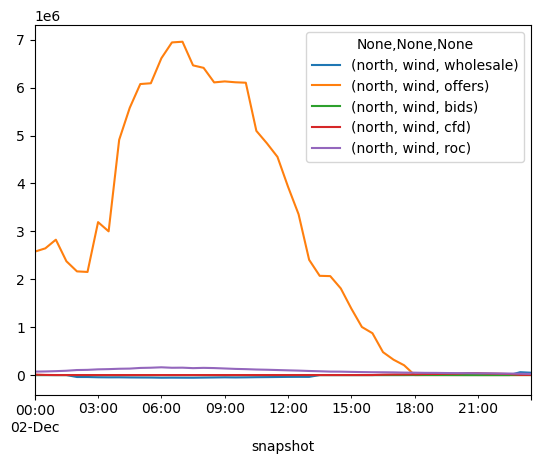

In [45]:
# rev.loc['2024-12-04',idx['north','water',:]].plot()
rev.loc['2024-12-02', idx['north','wind',:]].plot()

In [107]:
minidx = rev.loc[:,idx['north','water','bids']].argmin()
rev.index[minidx]

Timestamp('2022-11-29 02:00:00')

In [96]:
totals['zonal']

{'north disp': wholesale    2.440305e+08
 offers       8.665567e+08
 bids        -1.829300e+07
 cfd          0.000000e+00
 roc          0.000000e+00
 dtype: float64,
 'south disp': wholesale    5.502318e+10
 offers       2.955273e+08
 bids        -6.918722e+08
 cfd          0.000000e+00
 roc          0.000000e+00
 dtype: float64,
 'north water': wholesale    4.785727e+08
 offers       2.398674e+18
 bids        -8.270296e+17
 cfd          0.000000e+00
 roc          0.000000e+00
 dtype: float64,
 'south water': wholesale    4.473022e+08
 offers       3.460939e+18
 bids        -5.495305e+17
 cfd          0.000000e+00
 roc          0.000000e+00
 dtype: float64,
 'north wind': wholesale    5.333890e+07
 offers       5.227853e+09
 bids         1.008063e+05
 cfd          4.201156e+07
 roc          3.613934e+09
 dtype: float64,
 'south wind': wholesale    1.492992e+10
 offers       8.174059e+04
 bids         0.000000e+00
 cfd          6.291174e+08
 roc          1.013803e+10
 dtype: float64}

In [74]:
import pypsa

n = pypsa.Network(
        Path.cwd().parent / 'results' / '2024-12-02' / 'network_flex_s_nodal_solved.nc'
)

INFO:pypsa.io:Imported network network_flex_s_nodal_solved.nc has buses, carriers, generators, links, loads, storage_units


In [86]:
i = n.links.loc[n.links.carrier == 'interconnector'].index
n.links.loc[i]

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt,underwater_fraction,ramp_rate_down,tags,under_construction,geometry,ramp_rate_up,underground
Link,,,,,,,,,,,,,,,,,,,,,
BritNed,Netherlands,4969,,interconnector,0.99,True,0,inf,1133.0,0.0,...,1.0,1.0,1133.0,NaN,501.0,,NaN,,501.0,NaN
IFA1,France,4977,,interconnector,0.99,True,0,inf,2000.0,0.0,...,1.0,1.0,2000.0,NaN,1031.0,,NaN,,1031.0,NaN
IFA2,France,4955,,interconnector,0.99,True,0,inf,1870.0,0.0,...,1.0,1.0,1870.0,NaN,792.0,,NaN,,792.0,NaN
Nemo,Belgium,4975,,interconnector,0.99,True,0,inf,1000.0,0.0,...,1.0,1.0,1000.0,NaN,961.0,,NaN,,961.0,NaN
Viking,Denmark,7909,,interconnector,0.99,True,0,inf,1403.0,0.0,...,1.0,1.0,1403.0,NaN,726.0,,NaN,,726.0,NaN
ElecLink,France,5269,,interconnector,0.99,True,0,inf,1000.0,0.0,...,1.0,1.0,1000.0,NaN,300.0,,NaN,,300.0,NaN
NSL,Norway,5950,,interconnector,0.99,True,0,inf,1400.0,0.0,...,1.0,1.0,1400.0,NaN,450.0,,NaN,,450.0,NaN


<Axes: xlabel='snapshot'>

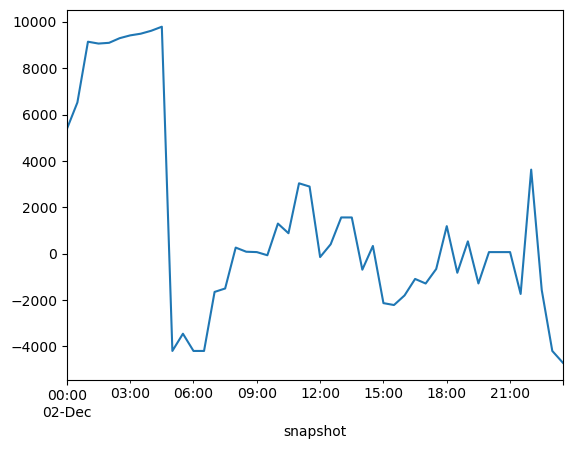

In [87]:
n.links_t.p0[i].sum(axis=1).plot()

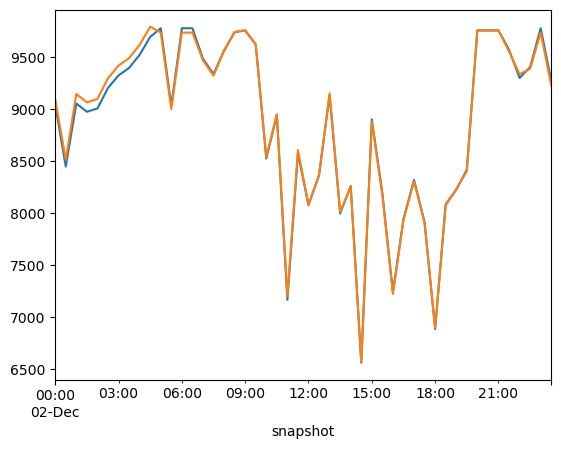

In [84]:
fig, ax = plt.subplots()
n.statistics.supply(comps=['Link'], aggregate_time=False).loc[idx['Link', 'interconnector']].plot(ax=ax)
n.statistics.withdrawal(comps=['Link'], aggregate_time=False).loc[idx['Link', 'interconnector']].plot(ax=ax)
plt.show()

In [20]:
rev.T.groupby(level=[0,1]).sum().T.sum().sort_index(level=1)

north  disp     1.458374e+09
south  disp     5.680355e+10
north  water    1.534691e+09
south  water    5.476507e+08
north  wind     1.317783e+10
south  wind     2.613871e+10
dtype: float64

In [138]:
day = '2022-11-29'

path = str(Path.cwd().parent / 'results' / '{}'  / 'bmu_revenues_flex_{}.csv')

zon = pd.read_csv(path.format(day, 'zonal'), index_col=0, header=[0,1,2], parse_dates=True)

In [139]:
zon.sum().sort_values()

south  disp   bids        -1.644673e+06
       wind   cfd         -5.799604e+05
north  wind   cfd         -3.449497e+05
       water  roc          0.000000e+00
south  water  bids         0.000000e+00
              offers       0.000000e+00
       disp   roc          0.000000e+00
              cfd          0.000000e+00
              offers       0.000000e+00
       wind   bids         0.000000e+00
              offers       0.000000e+00
       water  cfd          0.000000e+00
north  water  cfd          0.000000e+00
south  water  roc          0.000000e+00
north  water  offers       0.000000e+00
       disp   roc          0.000000e+00
              cfd          0.000000e+00
              bids         0.000000e+00
       wind   bids         0.000000e+00
              offers       0.000000e+00
       water  bids         0.000000e+00
       wind   roc          6.858950e+05
south  water  wholesale    8.417750e+05
       wind   roc          9.423970e+05
north  disp   wholesale    1.580580e+06


In [ ]:
path = str(Path.cwd().parent / 'summaries' / 'total_summary_revenues_{}.csv')
rev = pd.read_csv(path.format(''), index_col=0, header=[0,1,2], parse_dates=True)

rev.loc['2022-11-29'].sum().sort_values()

north  water  bids        -6.582777e+16
south  water  bids        -6.528644e+16
       disp   bids        -5.679807e+06
       wind   cfd         -5.799604e+05
north  wind   cfd         -3.449497e+05
       water  roc          0.000000e+00
south  disp   roc          0.000000e+00
              cfd          0.000000e+00
              offers       0.000000e+00
       wind   bids         0.000000e+00
              offers       0.000000e+00
       water  cfd          0.000000e+00
north  water  cfd          0.000000e+00
south  water  roc          0.000000e+00
north  disp   roc          0.000000e+00
              cfd          0.000000e+00
              bids         0.000000e+00
       wind   bids         0.000000e+00
              offers       0.000000e+00
              roc          6.858950e+05
south  water  wholesale    8.417750e+05
       wind   roc          9.423970e+05
north  disp   wholesale    1.580580e+06
south  wind   wholesale    3.321961e+06
north  wind   wholesale    3.815020e+06


In [128]:
import pypsa

n = pypsa.Network(Path.cwd().parent / 'results' / '2022-11-29' / 'network_flex_s_national_solved.nc')

INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units


<Axes: xlabel='snapshot'>

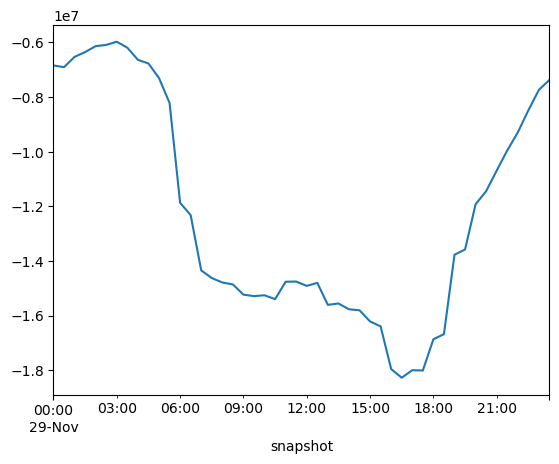

In [131]:
# help(n.statistics.revenue)
n.statistics.revenue(aggregate_time=False, comps='Load').loc['electricity'].plot()